In [69]:
# https://github.com/Davisy

# import important modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from string import punctuation 

# sklearn modules
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix, 
    ConfusionMatrixDisplay,
    f1_score,
    roc_auc_score,
)
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import cross_val_score, RandomizedSearchCV

# text preprocessing modules
from nltk.tokenize import word_tokenize

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer 
import re #regular expression


from wordcloud import WordCloud, STOPWORDS

# Download dependency
for dependency in (
    "brown",
    "names",
    "wordnet",
    "averaged_perceptron_tagger",
    "universal_tagset",
):
    nltk.download(dependency)


import warnings
warnings.filterwarnings("ignore")
# seeding
np.random.seed(123)

[nltk_data] Downloading package brown to /home/juanjo/nltk_data...
[nltk_data]   Package brown is already up-to-date!
[nltk_data] Downloading package names to /home/juanjo/nltk_data...
[nltk_data]   Package names is already up-to-date!
[nltk_data] Downloading package wordnet to /home/juanjo/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/juanjo/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package universal_tagset to
[nltk_data]     /home/juanjo/nltk_data...
[nltk_data]   Package universal_tagset is already up-to-date!


In [70]:
# load data
data = pd.read_csv("datasets/spam.tsv", sep="\t")

In [71]:
# show top five rows
data.head()

,label,message,length,punct
0,ham,"Go until jurong point, crazy.. Available only ...",111,9
1,ham,Ok lar... Joking wif u oni...,29,6
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155,6
3,ham,U dun say so early hor... U c already then say...,49,6
4,ham,"Nah I don't think he goes to usf, he lives aro...",61,2


In [72]:
# check missing values
data.isnull().sum()

label      0
message    0
length     0
punct      0
dtype: int64

In [73]:
# check the shape
data.shape

(5572, 4)

In [74]:
# evalute class distribution
data["label"].value_counts()

ham     4825
spam     747
Name: label, dtype: int64

In [75]:
# explore ham labeled sms
def collect_words(data, label):
    collected_words = " "

    # iterate through the csv file
    for val in data.message[data["label"] == label]:

        # typecaste each val to string
        val = str(val)

        # split the value
        tokens = val.split()

        # Converts each token into lowercase
        for i in range(len(tokens)):
            tokens[i] = tokens[i].lower()

        for words in tokens:
            collected_words = collected_words + words + " "

    return collected_words

Total words 349132


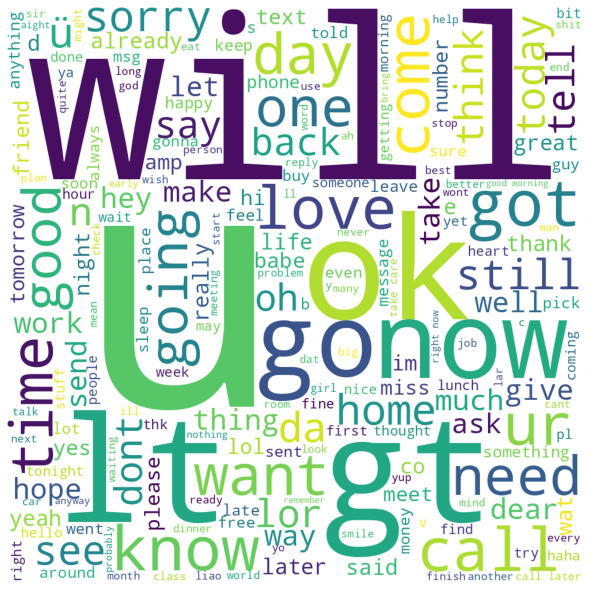

In [76]:
# visualize ham labeled sms
cloud_stopwords = set(STOPWORDS)
ham_words = collect_words(data, label="ham")

print("Total words {}".format(len(ham_words)))

wordcloud = WordCloud(
    width=1000,
    height=1000,
    background_color="white",
    stopwords=cloud_stopwords,
    min_font_size=10,
).generate(ham_words)

# plot the WordCloud image
plt.figure(figsize=(15, 8), facecolor=None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)

plt.show()

Total words 104304


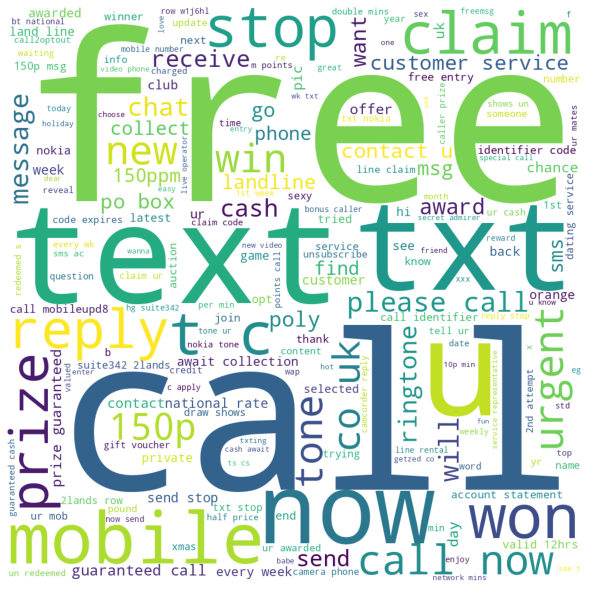

In [77]:
# visualize spam labeled sms
cloud_stopwords = set(STOPWORDS)
spam_words = collect_words(data, label="spam")

print("Total words {}".format(len(spam_words)))

wordcloud = WordCloud(
    width=1000,
    height=1000,
    background_color="white",
    stopwords=cloud_stopwords,
    min_font_size=10,
).generate(spam_words)

# plot the WordCloud image
plt.figure(figsize=(10, 8), facecolor=None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)

plt.show()

In [78]:
# show spam messages
data[data["label"] == "spam"].sample(10)

,label,message,length,punct
879,spam,U have a secret admirer who is looking 2 make ...,132,3
3860,spam,Win the newest Harry Potter and the Order of ...,138,5
3167,spam,HOT LIVE FANTASIES call now 08707509020 Just 2...,101,3
1069,spam,Someone U know has asked our dating service 2 ...,134,3
2220,spam,You have WON a guaranteed £1000 cash or a £200...,154,2
3382,spam,"complimentary 4 STAR Ibiza Holiday or £10,000 ...",149,4
2850,spam,YOUR CHANCE TO BE ON A REALITY FANTASY SHOW ca...,151,3
1940,spam,More people are dogging in your area now. Call...,159,6
5141,spam,FREE for 1st week! No1 Nokia tone 4 ur mobile ...,162,7
2575,spam,Your next amazing xxx PICSFREE1 video will be ...,153,2


In [79]:
# show normal messages
data[data["label"] == "ham"].sample(10)

,label,message,length,punct
4098,ham,i am going to bed now prin,26,0
4549,ham,Hope you are having a good week. Just checking in,49,1
168,ham,"Hi frnd, which is best way to avoid missunders...",74,3
4677,ham,Ü ready then call me...,23,3
4420,ham,How have your little darlings been so far this...,122,4
1315,ham,Got but got 2 colours lor. One colour is quite...,122,5
1348,ham,She doesnt need any test.,25,1
3105,ham,That's y i said it's bad dat all e gals know u...,66,6
112,ham,Going for dinner.msg you after.,31,2
4308,ham,I guess it is useless calling u 4 something im...,54,1


In [80]:
# replace ham to 0 and spam to 1
new_data = data.replace({"ham": 0, "spam": 1})
new_data.head()

,label,message,length,punct
0,0,"Go until jurong point, crazy.. Available only ...",111,9
1,0,Ok lar... Joking wif u oni...,29,6
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155,6
3,0,U dun say so early hor... U c already then say...,49,6
4,0,"Nah I don't think he goes to usf, he lives aro...",61,2


In [81]:
stop_words =  stopwords.words('english')

def text_cleaning(text, remove_stop_words=True, lemmatize_words=True):
    # Clean the text, with the option to remove stop_words and to lemmatize word

    # Clean the text
    text = re.sub(r"[^A-Za-z0-9]", " ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"I'm", "I am", text)
    text = re.sub(r"ur", " your ", text)
    text = re.sub(r" nd "," and ",text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r" tkts "," tickets ",text)
    text = re.sub(r" c "," can ",text)
    text = re.sub(r" e g ", " eg ", text)
    text =  re.sub(r'http\S+',' link ', text)
    text = re.sub(r'\b\d+(?:\.\d+)?\s+', '', text) # remove numbers
    text = re.sub(r" u "," you ",text)
    text = text.lower()  # set in lowercase 
        
    # Remove punctuation from text
    text = ''.join([c for c in text if c not in punctuation])
    
    # Optionally, remove stop words
    if remove_stop_words:
        text = text.split()
        text = [w for w in text if not w in stop_words]
        text = " ".join(text)
    
    # Optionally, shorten words to their stems
    if lemmatize_words:
        text = text.split()
        lemmatizer = WordNetLemmatizer() 
        lemmatized_words = [lemmatizer.lemmatize(word) for word in text]
        text = " ".join(lemmatized_words)
    
    # Return a list of words
    return(text)

In [82]:
#clean the dataset 
new_data["clean_message"] = new_data["message"].apply(text_cleaning)

In [83]:
new_data["clean_message"].head()

0    go j ong point crazy available bugis n great w...
1                                ok lar joking wif oni
2    free entry wkly comp win fa cup final ticket 2...
3                    u dun say early hor u already say
4                  nah think go usf life around though
Name: clean_message, dtype: object

In [84]:
# split data into train and test
X_train, X_test, y_train, y_test = train_test_split(
    new_data["clean_message"],
    new_data["label"],
    test_size=0.15,
    random_state=0,
    shuffle=True,
    stratify=data["label"],
)

In [85]:
# Transform text data 
vectorizer = CountVectorizer(lowercase=False)
vectorizer.fit(X_train)

#transform train data 
X_train_trans = vectorizer.transform(X_train)

#transform test data
X_text_trans = vectorizer.transform(X_test)

In [86]:
# Create a classifier
spam_classifier = MultinomialNB()

In [87]:
# Train the model with cross validation
scores = cross_val_score(spam_classifier,X_train_trans,y_train,cv=10,verbose=3,n_jobs=-1)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.0s finished


In [88]:
# find the mean of the all scores
scores.mean()

0.9767713936539371

In [89]:
# fine turning model parameters
distribution = {"alpha": [1, 0.1, 0.01, 0.001, 0.0001, 0, 0.2, 0.3]}

grid = RandomizedSearchCV(
    spam_classifier,
    param_distributions=distribution,
    n_jobs=-1,
    cv=10,
    n_iter=20,
    random_state=42,
    return_train_score=True,
    verbose=2,
)

In [90]:
# training with randomized search
grid.fit(X_train_trans, y_train)

Fitting 10 folds for each of 8 candidates, totalling 80 fits


RandomizedSearchCV(cv=10, estimator=MultinomialNB(), n_iter=20, n_jobs=-1,
                   param_distributions={'alpha': [1, 0.1, 0.01, 0.001, 0.0001,
                                                  0, 0.2, 0.3]},
                   random_state=42, return_train_score=True, verbose=2)

In [91]:
# summarize the results of the random parameter search
print(grid.best_score_)
print(grid.best_estimator_)
print(grid.best_params_)

0.9767713936539371
MultinomialNB(alpha=1)
{'alpha': 1}


In [92]:
# Train the model with best parameters
best_classifier = MultinomialNB(alpha=1)

In [93]:
#cross validation
scores = cross_val_score(best_classifier, X_train_trans, y_train, cv=10, verbose=2, n_jobs=-1)

print(scores)
print(scores.mean())

[0.96624473 0.97468354 0.98312236 0.98101266 0.97679325 0.98945148
 0.97040169 0.97674419 0.97463002 0.97463002]
0.9767713936539371


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.0s finished


In [94]:
# train the best_classifier 
best_classifier.fit(X_train_trans,y_train)

MultinomialNB(alpha=1)

In [114]:
# https://www.v7labs.com/blog/confusion-matrix-guide
from sklearn import metrics

print(X_text_trans)


  (0, 1170)	1
  (0, 2089)	1
  (0, 2419)	1
  (0, 2502)	1
  (0, 2549)	1
  (0, 2687)	1
  (0, 3501)	1
  (0, 3685)	1
  (0, 3986)	1
  (0, 4096)	1
  (0, 4276)	1
  (0, 5494)	1
  (0, 5609)	1
  (0, 6232)	1
  (1, 784)	1
  (1, 1129)	1
  (1, 3181)	1
  (1, 3807)	1
  (1, 4464)	1
  (1, 4518)	1
  (1, 5759)	1
  (1, 5882)	1
  (2, 451)	1
  (2, 2576)	1
  (2, 3930)	1
  :	:
  (833, 1152)	1
  (833, 1647)	1
  (833, 1752)	1
  (833, 3707)	1
  (833, 4564)	1
  (833, 4917)	1
  (833, 4935)	1
  (833, 5218)	1
  (833, 5301)	1
  (833, 6217)	1
  (833, 6303)	1
  (834, 2257)	1
  (834, 4292)	1
  (835, 113)	1
  (835, 383)	1
  (835, 1219)	1
  (835, 1263)	1
  (835, 1645)	1
  (835, 2153)	1
  (835, 3962)	1
  (835, 6257)	1
  (835, 6267)	1
  (835, 6663)	1
  (835, 6695)	2
  (835, 6770)	1


In [115]:
print(y_test)

3419    1
3991    1
3708    0
4318    0
4533    0
       ..
4156    1
4150    0
4673    1
691     0
2779    1
Name: label, Length: 836, dtype: int64


In [146]:
# predict on the test data
y_pred = best_classifier.predict(X_text_trans)
y_pred

array([0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0,

In [119]:
# check the classification report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.99      0.99       724
           1       0.93      0.88      0.91       112

    accuracy                           0.98       836
   macro avg       0.96      0.94      0.95       836
weighted avg       0.98      0.98      0.98       836



In [130]:
cm = confusion_matrix(y_test,y_pred)
cm

array([[717,   7],
       [ 13,  99]])

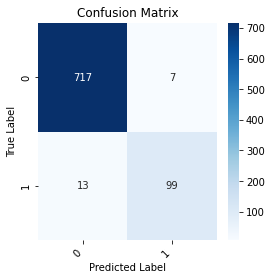

In [145]:
import seaborn as sns

def plot_confusion_matrix(y_test, y_pred, normalize=None,
                          title='Confusion Matrix', plot_numbers=True, display_names=None,
                          figsize=(4, 4)):

    cm = confusion_matrix(y_test, y_pred, normalize=normalize)
          
    df_cm = pd.DataFrame(cm, index=display_names, columns=display_names)
    fig = plt.figure(figsize=figsize)
    sns.heatmap(df_cm, annot=plot_numbers, cmap='Blues', fmt='g')
    
    plt.setp(plt.gca().get_xticklabels(), ha="right", rotation=45)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.title(title)
#   return fig

plot_confusion_matrix(y_test, y_pred)

In [120]:
# check accuracy score
accuracy_score(y_test, y_pred)

0.9760765550239234

In [121]:
# check f1_ score
f1_score(y_test, y_pred)

0.908256880733945

In [122]:
#save model 
import joblib 

joblib.dump(best_classifier, 'models/spam-detection-model.pkl')

['models/spam-detection-model.pkl']

In [123]:
#save transformer 
joblib.dump(vectorizer,'models/count_vectorizer.pkl')

['models/count_vectorizer.pkl']